In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# combine
# fill in make
# fill in age
# fill in power and engine cap
# fill in policy-related values except depreciation rate
# calculate price based on depreciation rate

In [136]:
df1 = pd.read_csv('./train.csv')
df2 = pd.read_csv('./test.csv')
l = df2.columns.tolist()
df1 = df1[l]
df = pd.concat([df1, df2])
trainLen = len(df1) - 1

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         5000 non-null   int64  
 1   title              5000 non-null   object 
 2   make               4373 non-null   object 
 3   model              5000 non-null   object 
 4   description        4889 non-null   object 
 5   manufactured       4939 non-null   float64
 6   original_reg_date  100 non-null    object 
 7   reg_date           4939 non-null   object 
 8   type_of_vehicle    5000 non-null   object 
 9   category           5000 non-null   object 
 10  transmission       5000 non-null   object 
 11  curb_weight        4844 non-null   float64
 12  power              4325 non-null   float64
 13  fuel_type          1051 non-null   object 
 14  engine_cap         4985 non-null   float64
 15  no_of_owners       4944 non-null   float64
 16  depreciation       4868 

df_valid = df.dropna(subset = ['fuel_type'])

missingfuel_type = df.fuel_type.isnull()
dfm = df[missingfuel_type]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in df_valid.iterrows():
    model = row['model']
    fuel_type = row['fuel_type']
    mapper[model] = fuel_type

for idx, row in dfm.iterrows():
    model = row['model']
    if model in mapper:
        df.at[idx, 'fuel_type'] = mapper[model]

print(df['fuel_type'].isnull().sum())

In [138]:
df_valid = df.dropna(subset = ['mileage', 'mileage'])
no_of_ownerss = df_valid['no_of_owners'].to_numpy()
caps = df_valid['mileage'].to_numpy()

k = 100
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['no_of_owners'], row['mileage']
    
    if type(row["mileage"]) == float and pd.isna(row["mileage"]):

        diff = np.abs(no_of_ownerss - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'mileage'] = avg
print(df['mileage'].isnull().sum())

0
0


In [139]:
d1 = df['manufactured'].isnull()
df['age'] = df['manufactured'].copy()
df['age'][d1] = df['manufactured'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['original_reg_date'][d1]
def month(x):
    if pd.isna(x):
        return np.nan
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return (2021 - int(x)) * 12
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

def filterNeg(x):
    if x < 0:
        return 0
    return x
    
df['age'] = df['age'].map(month)

d1 = df['reg_date'].isnull()
df['remaining_coe'] = df['reg_date'].copy()
df['remaining_coe'][d1] = df['reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['original_reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['manufactured'][d1]
df['remaining_coe'] = 120 - df['remaining_coe'].map(month)
df['remaining_coe'] = df['remaining_coe'].map(filterNeg)

hasLifeSpan = ~df['lifespan'].isnull()
def get_remaining(x):
    diffFrom2021 = month(x)
    res = -diffFrom2021
    if res < 0:
        res = 0
    return res ##check 2021
df['remaining_coe'][hasLifeSpan] = df['lifespan'][hasLifeSpan].map(get_remaining)


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
G:\software

In [149]:
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age']
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [150]:
missingOmv = df.omv.isnull()
# print(df[missingOmv]['category'].unique())
# print(df[missingOmv][df.category.str.contains('low mileage')])
# print(df[missingOmv][df.age < 120]['category'])
print(df[missingOmv])

      listing_id                                              title  \
706       861845               Lotus Super Seven (COE till 03/2028)   
1026      974600                    Morris Minor (COE till 06/2030)   
1889      772738              Mercedes-Benz 250S (COE till 04/2029)   
1904     1007657  Jaguar E-Type Series 1 Roadster 3.8M (COE till...   
2062     1018356          Volkswagen Beetle 1200 (COE till 03/2030)   
2282      786155                  Mercedes-Benz 200 (New 10-yr COE)   
2633      982455                       Fiat 500C (COE till 06/2030)   
3224      970068               Mercedes-Benz 200 (COE till 12/2030)   

               make   model  \
706           lotus   super   
1026         morris   minor   
1889  mercedes-benz     250   
1904         jaguar  e-type   
2062     volkswagen  beetle   
2282  mercedes-benz     200   
2633           fiat     500   
3224  mercedes-benz     200   

                                            description  manufactured  \
706   o

In [151]:
df_valid = df.dropna(subset = ['omv'])
df_valid = pd.concat([df_valid, df_train], axis = 0)
# print(df_valid.shape)
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    omv = row['omv']
    mapper[model].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'omv'] = np.average(mapper[model])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [153]:
print(df[df.omv.isnull()])

     listing_id                                 title   make  model  \
706      861845  Lotus Super Seven (COE till 03/2028)  lotus  super   

                                           description  manufactured  \
706  only lotus s4 unit in the market! original sin...        1972.0   

    original_reg_date     reg_date type_of_vehicle  \
706       31-jul-1972  24-oct-1973      sports car   

                                              category  ... omv  arf  \
706  imported used vehicle, coe car, rare & exotic,...  ... NaN  NaN   

     opc_scheme lifespan   eco_category  \
706         NaN      NaN  uncategorized   

                                              features  \
706  1.3l, inline 4 engine, producing 105bhp and 14...   

                                           accessories  indicative_price  age  \
706  13" sports rims, roll over bar, hollbay tuned ...               NaN  588   

     remaining_coe  
706              0  

[1 rows x 31 columns]


In [156]:
df_valid = df.dropna(subset = ['omv'])
df_valid = pd.concat([df_valid, df_train], axis = 0)
df.at[706, 'omv'] = np.average(df_valid[df_valid.age > 500]['omv'])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, age, remaining_coe]
Index: []

[0 rows x 31 columns]


In [143]:
vintage = df_train[df_train.age > 120].dropna(subset=['omv'])

In [144]:
## estimated omv
from sklearn.linear_model import LinearRegression
df_ = vintage.copy()
price = np.array(df_['price']).reshape(-1, 1)

age = np.array(df_['age']).reshape(-1, 1)

mileage = np.array(df_['mileage']).reshape(-1, 1)

X = np.concatenate((price, mileage, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)


0.6159344005524925
[[ 4.08490354e-01 -5.88514510e-02 -8.17139997e+01]]


In [145]:
missingPriceAges = []
missingVintage = df[df.omv.isnull()][df.age >= 120]
idxs = missingVintage.index
# print(len(missingVintage))
for idx, row in missingVintage.iterrows():
    price = row['price']
    mileage = row['mileage']
    age = row['age']
    missingPriceAges.append((price, mileage, age))
# print(len(missingPriceAges))
omvs = reg.predict(np.array(missingPriceAges))
count = 0
for i in idxs:
    df.at[i, 'omv'] = omvs[count]
    count += 1
print(df['omv'].isnull().sum())

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


KeyError: 'price'

In [113]:
# get the omv through regressor
df_ = df[df.category.str.contains('low mileage')][df.price > 250000].copy()
df_ = df_.dropna(subset=['omv'])
price = np.array(df_['price']).reshape(-1, 1)

age = np.array(df_['age']).reshape(-1, 1)

mileage = np.array(df_['mileage']).reshape(-1, 1)

X = np.concatenate((price, mileage, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)

0.5917591109482048
[[0.28842062 1.96206857 8.78531653]]


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [114]:
missingPriceAges = []
missing = df[df.omv.isnull()]
idxs = missing.index

for idx, row in missing.iterrows():
    price = row['price']
    mileage = row['mileage']
    age = row['age']
    missingPriceAges.append((price, mileage, age))
# print(len(missingPriceAges))
omvs = reg.predict(np.array(missingPriceAges))
count = 0
for i in idxs:
    df.at[i, 'omv'] = omvs[count]
    count += 1
print(df['omv'].isnull().sum())

0


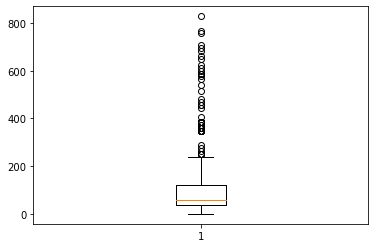

In [157]:
plt.boxplot(df['age'])
plt.show()

In [116]:
print(df[df.age > 20000])
print(df[df.age < 0])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, price, age, remaining_coe]
Index: []

[0 rows x 32 columns]
      listing_id                                              title  \
6300      976150  Mercedes-Benz G-Class G350d AMG Line 4MATIC Pr...   

               make model                                        description  \
6300  mercedes-benz   amg  5 years warranty or 130,000km. call our friend...   

      manufactured original_reg_date     reg_date type_of_vehicle  \
6300        2925.0               NaN  03-mar-2021             suv   

                                               category  ...       arf  \
6300  parf car, almost new car, premium ad car, low ...  ...  169412.0   

In [117]:
df['age'][df.age < 0] = 0
df['age'][df.age > 20000] = 0

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
##train
print(df[df.engine_cap == 0])
df.at[8199, 'engine_cap'] = np.nan

      listing_id                                              title make  \
8199     1005670  Mercedes-Benz E-Class E300e Plug-in Hybrid AMG...  NaN   

     model                                        description  manufactured  \
8199   amg  great deal! grab it! new facelifted 2021 with ...        2021.0   

     original_reg_date     reg_date type_of_vehicle  \
8199               NaN  16-jun-2021    luxury sedan   

                                               category  ...      arf  \
8199  parf car, almost new car, low mileage car, hyb...  ...  66486.0   

      opc_scheme  lifespan   eco_category  \
8199         NaN       NaN  uncategorized   

                                               features  \
8199  2.0l m274 powerplant with eq boost producing 3...   

                                            accessories  indicative_price  \
8199  amg kits and wheels, memory seat, ambient ligh...               NaN   

         price  age  remaining_coe  
8199  249700.0    0         

{'whiskers': [<matplotlib.lines.Line2D at 0x253de1d6a88>,
 'caps': [<matplotlib.lines.Line2D at 0x253dd1212c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x253dd121688>],
 'medians': [<matplotlib.lines.Line2D at 0x253dce7a088>],
 'fliers': [<matplotlib.lines.Line2D at 0x253dd234688>],
 'means': []}

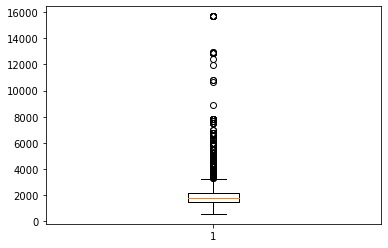

In [159]:
plt.boxplot(df['engine_cap'].dropna())

In [160]:
df_valid = df.dropna(subset = ['power'])
ps = df_valid['power'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['power']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'power'] = np.average(mapper[model])

print(df['power'].isnull().sum())

487


G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [161]:
df_valid = df.dropna(subset = ['engine_cap'])
ps = df_valid['engine_cap'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['engine_cap']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'engine_cap'] = np.average(mapper[model])

print(df['engine_cap'].isnull().sum())

15


G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [162]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

In [163]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0


df_ = df.copy()
df_['efficiency'] = df_['power']
for i in range(len(df_)):
    x = df_.iloc[i]
    df_['efficiency'][i] = x['power'] / x['engine_cap']

plt.boxplot(df_[df_.fuel_type == 'diesel']['efficiency'])# / diesel['engine_cap'])
plt.show()

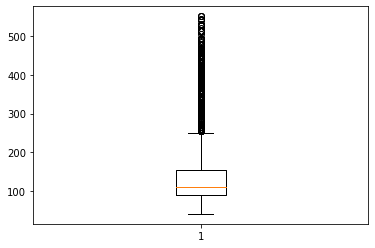

In [123]:
plt.boxplot(df['power'])# / diesel['engine_cap'])
plt.show()

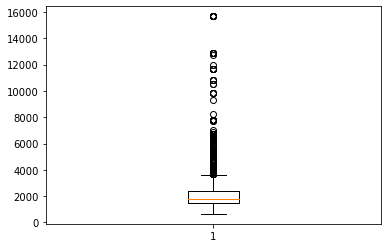

In [124]:
plt.boxplot(df['engine_cap'])# / diesel['engine_cap'])
plt.show()

plt.boxplot(df_[df_.fuel_type == 'petrol']['efficiency'])# / diesel['engine_cap']) ##outlier
plt.show()

# fill omv, get data with missing omv and dereg_value, fill in the omv
is_ = df[df.omv.isnull() & df.dereg_value.isnull()].index.tolist()
filled_omvs = []
for idx in is_:
    ag = df.at[idx, 'age']
    price = df.at[idx, 'price']
    mo = reg.predict(np.array([[ag, price]]))
    filled_omvs.append(mo)
for i, idx in enumerate(is_):
    df.at[idx, 'omv'] = filled_omvs[i]

In [164]:
avg = np.average(df['coe'].dropna())
df['coe'] = df['coe'].fillna(avg)

In [165]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull() & df.dereg_value.isnull()]['arf'].index.tolist()
for idx in fill_arf:
    omv = df.at[idx, 'omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull() & df.dereg_value.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

0


In [166]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

0


In [167]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

0
0


In [168]:
import math
for idx, row in df.iterrows():
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * row['remaining_coe'] / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [130]:
## train
df_train = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         16784 non-null  int64  
 1   title              16784 non-null  object 
 2   make               14624 non-null  object 
 3   model              16784 non-null  object 
 4   description        16439 non-null  object 
 5   manufactured       16590 non-null  float64
 6   original_reg_date  318 non-null    object 
 7   reg_date           16583 non-null  object 
 8   type_of_vehicle    16784 non-null  object 
 9   category           16784 non-null  object 
 10  transmission       16784 non-null  object 
 11  curb_weight        16205 non-null  float64
 12  power              16784 non-null  float64
 13  fuel_type          3490 non-null   object 
 14  engine_cap         16784 non-null  float64
 15  no_of_owners       16608 non-null  float64
 16  depreciation       163

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         5000 non-null   int64  
 1   title              5000 non-null   object 
 2   make               4373 non-null   object 
 3   model              5000 non-null   object 
 4   description        4889 non-null   object 
 5   manufactured       4939 non-null   float64
 6   original_reg_date  100 non-null    object 
 7   reg_date           4939 non-null   object 
 8   type_of_vehicle    5000 non-null   object 
 9   category           5000 non-null   object 
 10  transmission       5000 non-null   object 
 11  curb_weight        4844 non-null   float64
 12  power              5000 non-null   float64
 13  fuel_type          1051 non-null   object 
 14  engine_cap         5000 non-null   float64
 15  no_of_owners       4944 non-null   float64
 16  depreciation       4868 

In [170]:
# drop irrelevant
df = df.drop(columns = ['title', 'make', 'model', 'description', 'arf', 'original_reg_date','reg_date', 'opc_scheme', 'listing_id', 'indicative_price', 'manufactured', 'no_of_owners', 'lifespan', 'eco_category', 'accessories', 'depreciation', 'road_tax', 'features'])

In [171]:
df = df.drop(columns = ['curb_weight', 'fuel_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type_of_vehicle  5000 non-null   object 
 1   category         5000 non-null   object 
 2   transmission     5000 non-null   object 
 3   power            5000 non-null   float64
 4   engine_cap       5000 non-null   float64
 5   coe              5000 non-null   float64
 6   dereg_value      5000 non-null   float64
 7   mileage          5000 non-null   float64
 8   omv              5000 non-null   float64
 9   age              5000 non-null   int64  
 10  remaining_coe    5000 non-null   int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 429.8+ KB


In [172]:
cars_dummies = pd.get_dummies(df['type_of_vehicle'])
df = pd.concat([df, cars_dummies], axis=1)
cars_dummies = pd.get_dummies(df['transmission'])
df = pd.concat([df, cars_dummies], axis=1)
df = df.drop(columns = ['type_of_vehicle', 'category', 'transmission'])

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   power            5000 non-null   float64
 1   engine_cap       5000 non-null   float64
 2   coe              5000 non-null   float64
 3   dereg_value      5000 non-null   float64
 4   mileage          5000 non-null   float64
 5   omv              5000 non-null   float64
 6   age              5000 non-null   int64  
 7   remaining_coe    5000 non-null   int64  
 8   bus/mini bus     5000 non-null   uint8  
 9   hatchback        5000 non-null   uint8  
 10  luxury sedan     5000 non-null   uint8  
 11  mid-sized sedan  5000 non-null   uint8  
 12  mpv              5000 non-null   uint8  
 13  others           5000 non-null   uint8  
 14  sports car       5000 non-null   uint8  
 15  stationwagon     5000 non-null   uint8  
 16  suv              5000 non-null   uint8  
 17  truck         

In [174]:
df.to_csv('numerical_cleaned_test.csv')